In [1]:
import pandas as pd
import numpy as np

In [2]:
# Meter readings from 2 buildings, 8784 1-hour samples each
df = pd.read_parquet('prepped.parquet')
df

,building_id,timestamp,meter_reading/sqft,anomaly,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,is_holiday
13,0,2016-01-01 00:00:00,0.000847,0,3.8,2.4,1020.9,240,3.1,1
15,1,2016-01-01 00:00:00,0.001523,0,3.8,2.4,1020.9,240,3.1,1
213,0,2016-01-01 01:00:00,0.001695,0,3.7,2.4,1021.6,230,2.6,1
215,1,2016-01-01 01:00:00,0.002990,0,3.7,2.4,1021.6,230,2.6,1
411,0,2016-01-01 02:00:00,0.001698,0,2.6,1.9,1021.9,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
1748909,1,2016-12-31 21:00:00,0.002794,0,6.9,5.8,1026.2,220,4.6,0
1749107,0,2016-12-31 22:00:00,0.002029,0,6.9,6.2,1025.4,190,3.1,0
1749109,1,2016-12-31 22:00:00,0.002960,0,6.9,6.2,1025.4,190,3.1,0
1749307,0,2016-12-31 23:00:00,0.002000,0,7.5,6.5,1024.7,210,5.7,0


In [3]:
# 0 - non-anomalous, 1 - anomalous
df.anomaly.value_counts()

0    17218
1      350
Name: anomaly, dtype: int64

In [4]:
# Split the data
X_full = df.query('timestamp < "2016-12"')
X_train = df.query('timestamp < "2016-11"')
X_val = df.query('timestamp >= "2016-11" and timestamp < "2016-12"')
X_test = df.query('timestamp >= "2016-12"')

y_full = X_full.pop('anomaly')
y_train = X_train.pop('anomaly')
y_val = X_val.pop('anomaly')
y_test = X_test.pop('anomaly')

### Detecting anomalies with a CatBoost classifier

In [5]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.metrics import ConfusionMatrixDisplay

In [6]:
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)
test_pool = Pool(X_test, y_test)
full_pool = Pool(X_full, y_full)

In [7]:
# Set class weights to address class imbalance
inlier, outlier = np.bincount(df.anomaly)
total = inlier + outlier
weight_for_0 = (1 / inlier) * (total / 2.0)
weight_for_1 = (1 / outlier) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}
class_weights

{0: 0.510163782088512, 1: 25.097142857142856}

In [8]:
# Create CatBoost model
cbc = CatBoostClassifier(iterations=2000, learning_rate=0.001, depth=6, eval_metric='PRAUC', loss_function='Logloss', class_weights=class_weights, random_seed=42)
cbc.fit(train_pool, eval_set=val_pool, early_stopping_rounds=200, verbose=100)

0:	learn: 0.8914466	test: 0.7416290	best: 0.7416290 (0)	total: 152ms	remaining: 5m 3s
100:	learn: 0.9850974	test: 0.8863931	best: 0.8870384 (99)	total: 762ms	remaining: 14.3s
200:	learn: 0.9866472	test: 0.8796311	best: 0.8870384 (99)	total: 1.39s	remaining: 12.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8870384053
bestIteration = 99

Shrink model to first 100 iterations.


PRAUC score: 0.74


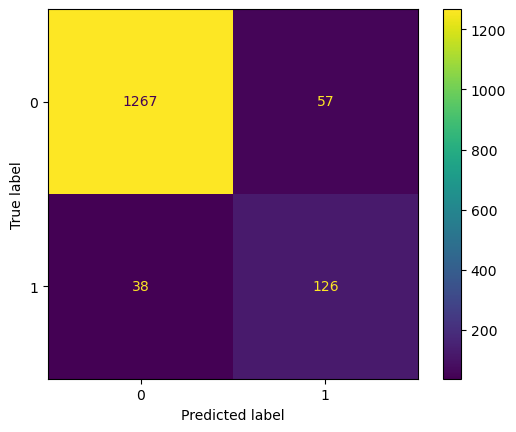

In [9]:
# Fit the model on the full data
cbc = CatBoostClassifier(iterations=100, learning_rate=0.001, depth=6, loss_function='Logloss', class_weights=class_weights, random_seed=42)
cbc.fit(full_pool, verbose=0)

# Evaluate the model
cbc_preds = cbc.predict(X_test)
cbc_score = eval_metric(y_test.to_numpy(), cbc_preds, metric='PRAUC')
print(f'PRAUC score: {cbc_score[0]:.2f}')
ConfusionMatrixDisplay.from_predictions(y_test, cbc_preds);

The model manages to detect 126/164 anomalies while not having many false positives.

In [11]:
# Tune the model by increasing depth by 2
cbc2 = CatBoostClassifier(iterations=2000, learning_rate=0.001, depth=8, eval_metric='PRAUC', loss_function='Logloss', class_weights=class_weights, random_seed=42)
cbc2.fit(train_pool, eval_set=val_pool, early_stopping_rounds=200, verbose=100)

0:	learn: 0.9277058	test: 0.7789981	best: 0.7789981 (0)	total: 8.08ms	remaining: 16.1s
100:	learn: 0.9948044	test: 0.8766391	best: 0.8797279 (85)	total: 844ms	remaining: 15.9s
200:	learn: 0.9953685	test: 0.8777288	best: 0.8797279 (85)	total: 1.61s	remaining: 14.4s
300:	learn: 0.9967293	test: 0.8816211	best: 0.8822359 (284)	total: 2.33s	remaining: 13.2s
400:	learn: 0.9979084	test: 0.8833517	best: 0.8833984 (362)	total: 3.05s	remaining: 12.2s
500:	learn: 0.9984939	test: 0.8824700	best: 0.8835489 (405)	total: 3.79s	remaining: 11.3s
600:	learn: 0.9989033	test: 0.8805958	best: 0.8835489 (405)	total: 4.54s	remaining: 10.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8835488968
bestIteration = 405

Shrink model to first 406 iterations.


PRAUC score: 0.79


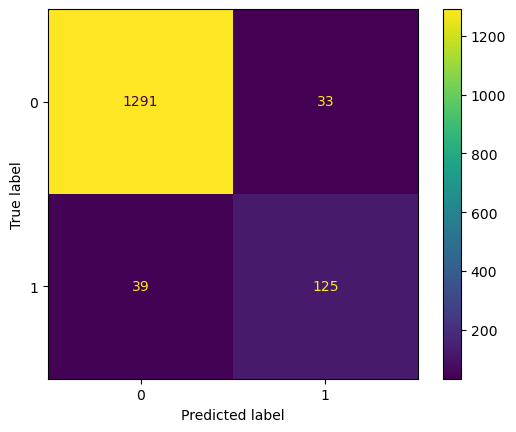

In [12]:
cbc2 = CatBoostClassifier(iterations=406, learning_rate=0.001, depth=8, loss_function='Logloss', class_weights=class_weights, random_seed=42)
cbc2.fit(full_pool, verbose=0)

cbc2_preds = cbc2.predict(X_test)
cbc2_score = eval_metric(y_test.to_numpy(), cbc2_preds, metric='PRAUC')
print(f'PRAUC score: {cbc2_score[0]:.2f}')
ConfusionMatrixDisplay.from_predictions(y_test, cbc2_preds);

Although the number of anomalies detected drops by 1 from 126 to 125, the false positives drop by nearly half from 57 to 33.

In [13]:
# Tune the model by decreasing depth by 2
cbc3 = CatBoostClassifier(iterations=2000, learning_rate=0.001, depth=4, eval_metric='PRAUC', loss_function='Logloss', class_weights=class_weights, random_seed=42)
cbc3.fit(train_pool, eval_set=val_pool, early_stopping_rounds=200, verbose=100)

0:	learn: 0.8151993	test: 0.8428853	best: 0.8428853 (0)	total: 5.31ms	remaining: 10.6s
100:	learn: 0.9602336	test: 0.9049395	best: 0.9136813 (55)	total: 470ms	remaining: 8.83s
200:	learn: 0.9643479	test: 0.8992750	best: 0.9136813 (55)	total: 895ms	remaining: 8.01s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9136812738
bestIteration = 55

Shrink model to first 56 iterations.


PRAUC score: 0.57


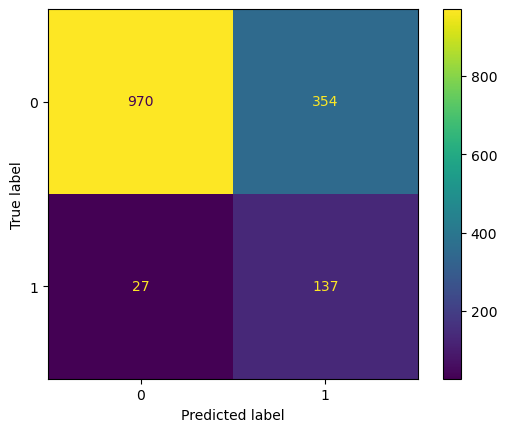

In [14]:
cbc3 = CatBoostClassifier(iterations=56, learning_rate=0.001, depth=4, loss_function='Logloss', class_weights=class_weights, random_seed=42)
cbc3.fit(full_pool, verbose=0)

cbc3_preds = cbc3.predict(X_test)
cbc3_score = eval_metric(y_test.to_numpy(), cbc3_preds, metric='PRAUC')
print(f'PRAUC score: {cbc3_score[0]:.2f}')
ConfusionMatrixDisplay.from_predictions(y_test, cbc3_preds);

The model detects 12 more anomalies than before, but comes at the cost of a significantly higher number of false positives. Overall, the second model with depth=8 is the best. 

### Detecting anomalies with an LSTM neural network

In [15]:
import tensorflow as tf
import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer

In [16]:
# Check which features have negative values
(df.set_index('timestamp') < 0).sum()

building_id              0
meter_reading/sqft       0
anomaly                  0
air_temperature        300
dew_temperature       1380
sea_level_pressure       0
wind_direction           0
wind_speed              42
is_holiday               0
dtype: int64

In [17]:
# Add the absolute min values of the features with negative values to themselves so that normalisation works smoothly
df.air_temperature = df.air_temperature + abs(df.air_temperature.min())
df.dew_temperature = df.dew_temperature + abs(df.dew_temperature.min())
df.wind_speed = df.wind_speed + abs(df.wind_speed.min())

Overview of model architecture:

<img src="multioverview.png"/>

In [18]:
# Custom loss function that allows class weights to be used for multiple inputs
class WeightedBinaryCrossentropy(tf.keras.losses.Loss):
    def __init__(self, class_weights):
        super(WeightedBinaryCrossentropy, self).__init__()
        self.class_weights_tensor = tf.constant(list(class_weights.values()), dtype=tf.float32)

    def call(self, y_true, y_pred):
        weighted_true = tf.multiply(tf.gather(self.class_weights_tensor, tf.cast(y_true, tf.int32)), tf.cast(y_true, tf.float32))
        loss = tf.nn.weighted_cross_entropy_with_logits(labels=weighted_true, logits=y_pred, pos_weight=1.0)
        return loss

weighted_binary_crossentropy = WeightedBinaryCrossentropy(class_weights)

In [19]:
def build_LSTM():
    input1 = layers.Input(shape=(48, 8), name='building_1')
    input2 = layers.Input(shape=(48, 8), name='building_2')
    lstm1 = layers.LSTM(16, recurrent_dropout=0.25, return_sequences=True, name='lstm1_1')(input1)
    lstm2 = layers.LSTM(16, recurrent_dropout=0.25, return_sequences=True, name='lstm1_2')(input2)
    lstm1 = layers.LSTM(8, name='lstm2_1')(lstm1)
    lstm2 = layers.LSTM(8, name='lstm2_2')(lstm2)
    concat = layers.Concatenate(name='concat')([lstm1, lstm2])
    dropout = layers.Dropout(0.5, name='dropout')(concat)
    outputs = layers.Dense(1, activation='sigmoid', name='dense_output')(dropout)

    model = keras.Model([input1, input2], outputs)
    model.compile(loss=weighted_binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=1e-05), metrics=keras.metrics.AUC(curve='PR', name='PRAUC'))
    return model

callbacks = [keras.callbacks.EarlyStopping(patience=20, monitor='val_loss')]

In [20]:
# Prepare the data
building_dict = {}
ct = make_column_transformer((MinMaxScaler(), np.arange(8)))
ct_full = make_column_transformer((MinMaxScaler(), np.arange(8)))

for building in df.building_id.unique():
    X = df.query('building_id == @building')

    X_full = X.query('timestamp < "2016-12"').drop(columns=['timestamp'])
    X_train = X.query('timestamp < "2016-11"').drop(columns=['timestamp'])
    X_val = X.query('timestamp >= "2016-11" and timestamp < "2016-12"').drop(columns=['timestamp'])
    X_test = X.query('timestamp >= "2016-12"').drop(columns=['timestamp'])

    y_full = X_full.pop('anomaly')
    y_train = X_train.pop('anomaly')
    y_val = X_val.pop('anomaly')
    y_test = X_test.pop('anomaly')

    X_full = ct_full.fit_transform(X_full).astype('float32')
    X_test = ct_full.transform(X_test).astype('float32')
    X_train = ct.fit_transform(X_train).astype('float32')
    X_val = ct.transform(X_val).astype('float32')

    # Use 168 hours (7 days) to predict the class of the 169th hour
    full_dataset = keras.utils.timeseries_dataset_from_array(X_full[:-168], 
                                                            y_full[168:], 
                                                            sequence_length=168,
                                                            batch_size=256)

    train_dataset = keras.utils.timeseries_dataset_from_array(X_train[:-168], 
                                                            y_train[168:], 
                                                            sequence_length=168,  
                                                            batch_size=256)

    validation_dataset = keras.utils.timeseries_dataset_from_array(X_val[:-168], 
                                                            y_val[168:], 
                                                            sequence_length=168,
                                                            batch_size=256)

    test_dataset = keras.utils.timeseries_dataset_from_array(X_test[:-168], 
                                                            y_test[168:], 
                                                            sequence_length=168,
                                                            batch_size=256)
    
    # Concatenate the train and label batches in each dataset as separate numpy arrays
    X_full = np.concatenate([x for x, y in full_dataset])
    y_full = np.concatenate([y for x, y in full_dataset])
    X_train = np.concatenate([x for x, y in train_dataset])
    y_train = np.concatenate([y for x, y in train_dataset])
    X_val = np.concatenate([x for x, y in validation_dataset])
    y_val = np.concatenate([y for x, y in validation_dataset])
    X_test = np.concatenate([x for x, y in test_dataset])
    y_test = np.concatenate([y for x, y in test_dataset])
    
    building_dict[building] = {'X_full': X_full, 'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
                               'y_full': y_full, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test}

# Combine the relevant data from each building into their respective lists
X_train_list = []
y_train_list = []
X_val_list= []
y_val_list = []
X_test_list = []
y_test_list = []
for building in df.building_id.unique():
    X_train_list.append(building_dict[building]['X_train'])
    y_train_list.append(building_dict[building]['y_train'])
    X_val_list.append(building_dict[building]['X_val'])
    y_val_list.append(building_dict[building]['y_val'])
    X_test_list.append(building_dict[building]['X_test'])
    y_test_list.append(building_dict[building]['y_test'])

In [ ]:
model = build_LSTM()
history = model.fit(X_train_list, y_train_list, validation_data=(X_val_list, y_val_list), epochs=200, batch_size=32, shuffle=False, callbacks=callbacks)

I was unable to get a good model fit despite extensively testing different hyperparameters, model complexity, and input sequence lengths. Unsure if it was because I implemented the model incorrectly or because of insufficient training data. Will revisit in future. 